In [252]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession


from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, TimestampType, DateType
from pyspark.sql.functions import udf, dense_rank, desc, asc
from pyspark.sql.functions import mean as _mean, min as _min, max as _max, sum as _sum, count as _count, datediff, to_date
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col, date_format

from pyspark.sql import functions as F
from pyspark.sql.functions import collect_set
from pyspark.sql.window import Window

import math
import numpy as np
import sys
import datetime as dt

from pylab import rcParams
import math
rcParams['figure.figsize'] = 15, 8







In [253]:
# method that print only blanks
def print_blanks(n=10):
    for i in range(n):
        print('\n')

# method that create connection with spark server
def create_spark_context(master_ip='127.0.0.1'):
    master_ip = 'spark://{}:7077'.format(master_ip)
    spark = SparkSession.builder \
        .master(master_ip)  \
        .enableHiveSupport() \
        .getOrCreate()
    
    sc = spark.sparkContext
    return (spark, sc)

spark, sc = create_spark_context()


In [254]:
input_filename = '../ressources/data/financial_sells_100000.csv'
csv_separator = ','


# read csv file
init_flat_data = spark.read         \
    .option("sep", csv_separator)  \
    .csv(input_filename, header=True)

# remove useless data
init_flat_data = init_flat_data.fillna(0)

init_flat_data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_id: string (nullable = true)
 |-- country: string (nullable = true)
 |-- sector_name: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- NBI: string (nullable = true)
 |-- order_date: string (nullable = true)



In [255]:
#cast columns

init_flat_data = init_flat_data \
    .withColumn('order_date', to_date(unix_timestamp("order_date", "yyyy-MM-dd").cast('timestamp')) ) \
    .withColumn('NBI', col('NBI').cast('float') ) \
    .withColumn('order_id', col('order_id').cast('int')) \
    .withColumn('company_id', col('company_id').cast('int'))




In [256]:
max_order_date, min_order_date = init_flat_data \
    .select( _max(col('order_date')), _min(col('order_date'))) \
    .take(1)[0]


In [257]:
calculate_diff_day = udf(lambda x: (max_order_date - x).days, IntegerType())
rfm_table = init_flat_data \
    .withColumn('recency', calculate_diff_day('order_date')) \
    .groupby(['company_name', 'country']) \
    .agg( 
        _mean(col('recency')).alias('recency'), 
        _count(col('order_id')).alias('frequency'),
        _sum(col('NBI')).alias('monetary')
    )



rfm_table.printSchema()

root
 |-- company_name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- recency: double (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary: double (nullable = true)



In [208]:
quantiles = rfm_table.approxQuantile(['recency', 'frequency', 'monetary'], [0.20, 0.4, 0.6, 0.8], 0)
r_quantile = quantiles[0]
f_quantile = quantiles[1]
m_quantile = quantiles[2]


print(f_quantile)
def_r_score = udf(lambda x: 5 if x < r_quantile[0] else 4 if x < r_quantile[1] else 3 if x < r_quantile[2] else 2 if x < r_quantile[3] else 1, IntegerType())
def_f_score = udf(lambda x: 1 if x < f_quantile[0] else 2 if x < f_quantile[1] else 3 if x < f_quantile[2] else 4 if x < f_quantile[3] else 5, IntegerType())
def_m_score = udf(lambda x: 1 if x < m_quantile[0] else 2 if x < m_quantile[1] else 3 if x < m_quantile[2] else 4 if x < m_quantile[3] else 5, IntegerType())

def_rfm_score = udf(lambda r, f, m: r*100 + f*10 + m , IntegerType())
def_seg_id = udf(lambda r, f: r*10 + f, StringType())

rfm_table = rfm_table  \
    .withColumn('r_score',  def_r_score('recency')) \
    .withColumn('f_score',  def_f_score('frequency')) \
    .withColumn('m_score',  def_m_score('monetary')) \
    .withColumn('rfm_score', def_rfm_score('r_score', 'f_score', 'm_score')) \
    .withColumn('segment_id', def_seg_id('r_score', 'f_score')  ) \
    .sort(asc('monetary')) 




[1961.0, 1985.0, 2008.0, 2037.0]


In [227]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

pd_df = rfm_table   \
    .select('company_name', 'country', 'segment_id')   \
    .toPandas()   \
    .replace(segt_map, regex=True)   \
    .rename(columns={'segment_id': 'segment_name'})
    

rfm_table = rfm_table  \
    .join(spark.createDataFrame(pd_df), how='left', on=['company_name', 'country'])


rfm_table.printSchema()

root
 |-- company_name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- recency: double (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary: double (nullable = true)
 |-- r_score: integer (nullable = true)
 |-- f_score: integer (nullable = true)
 |-- m_score: integer (nullable = true)
 |-- rfm_score: integer (nullable = true)
 |-- segment_id: string (nullable = true)
 |-- segment_name: string (nullable = true)
 |-- segment_name: string (nullable = true)



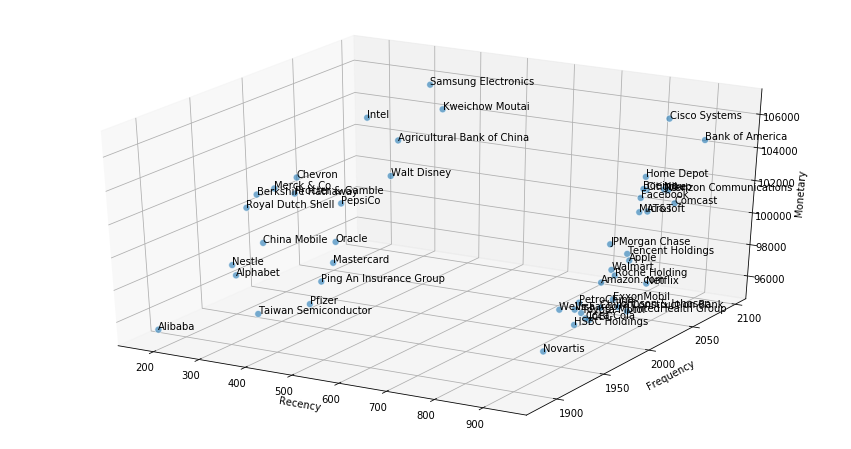

In [245]:
# plot to 3d axes

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pd_df = rfm_table.toPandas()


labels = pd_df['company_name'].values
xs = pd_df['recency'].values
ys = pd_df['frequency'].values
zs = pd_df['monetary'].values
c = pd_df['segment_id'].values

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')



for i in range(len(xs)):
    ax.text(xs[i], ys[i], zs[i], labels[i])
ax.scatter(xs, ys, zs, marker='o', s=50, alpha=0.6, edgecolors='w')

[-43.5400187  -41.63111558 -29.41771304 -44.50249276 -45.35385684
 -32.19885935 -37.34603661 -26.40938685 -28.1758802  -27.46322619
 -48.04974879 -48.88958151 -49.13694551 -28.23333382 -47.61178948
 -40.10349098 -43.28819991 -32.306166   -31.32605833 -36.48825845
 -38.91137733 -46.48588341 -38.76437806 -48.10432841 -42.41679055
 -39.8722084  -38.76585646 -42.14953263 -45.52673269 -34.48028061
 -43.39220247 -34.44878961 -46.1035487  -28.99882713 -34.32155285
 -27.33543456 -40.08218729 -44.72326557 -38.42647264 -46.62437219
 -44.91613313 -40.05054272 -29.00603238 -29.63680327 -28.63333646
 -49.07414154 -36.84282002 -27.00808617 -29.92908865 -29.81374087
 -44.65570161 -27.10790871 -47.93185547 -38.9793766  -36.06630974
 -28.7116254  -32.89089629 -38.5415422  -49.19256015 -47.69587328
 -28.53251614 -39.34994515 -48.82853017 -48.25301131 -27.71298208
 -25.69219799 -34.53076692 -31.84166316 -30.60225553 -29.98968243
 -30.09452913 -36.83955991 -48.27168739 -39.140772   -48.88007318
 -37.24647

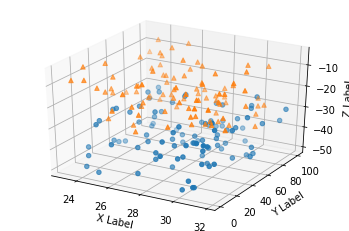

In [224]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np




def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()